In [1]:
import pandas
import seaborn
import sklearn
import functions as covid_lib
from numpy import hstack, array
from random import random
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from dash.dependencies import Input, Output 

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense


---
## 1st Dataset : John Hopkins Data

In [2]:
## John Hopkins Center for Systems Science and Engineer Data Base URL
## Contains timeseries data
## This set of data is updated daily
baseURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

cumulated_confirmed_url = baseURL + "time_series_covid19_confirmed_global.csv"
cumulated_deaths_url    = baseURL + "time_series_covid19_deaths_global.csv"
cumulated_recovered_url = baseURL + "time_series_covid19_recovered_global.csv"

cumulated_confirmed     = pd.read_csv(cumulated_confirmed_url)
cumulated_deaths        = pd.read_csv(cumulated_deaths_url)
cumulated_recovered     = pd.read_csv(cumulated_recovered_url)

## Processed Dataset
## Combine by Country/Region
cumulated_confirmed_country = covid_lib.df_groupby_countries(cumulated_confirmed)
cumulated_deaths_country = covid_lib.df_groupby_countries(cumulated_deaths)
cumulated_recovered_country = covid_lib.df_groupby_countries(cumulated_recovered)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# US_confirmed.to_csv('cululated_confirmed.csv', index = False)

In [4]:
print("Confirmed data shape : " + str(cumulated_confirmed_country.shape))
print("Recovered data shape : " + str(cumulated_deaths_country.shape))
print("Deaths data shape : " + str(cumulated_recovered_country.shape))

Confirmed data shape : (188, 179)
Recovered data shape : (188, 179)
Deaths data shape : (188, 179)


In [5]:
# ## To find specific instances on certain countries
# ## Consider grouping by countries to simplify the analysis process
# cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()

In [6]:
cumulated_confirmed_country.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20
0,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,...,33190,33384,33594,33908,34194,34366,34451,34455,34740,34994
1,Albania,41.15330,20.168300,0,0,0,0,0,0,0,...,2964,3038,3106,3188,3278,3371,3454,3571,3667,3752
2,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,...,16404,16879,17348,17808,18242,18712,19195,19689,20216,20770
3,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,...,855,855,855,855,855,855,855,858,861,862
4,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,...,346,386,386,396,458,462,506,525,541,576


In [7]:
unique_countries = cumulated_confirmed_country["Country/Region"].unique()

In [8]:
cumulated_deaths_country[cumulated_deaths_country["Country/Region"]=="Taiwan*"]


,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,7/6/20,7/7/20,7/8/20,7/9/20,7/10/20,7/11/20,7/12/20,7/13/20,7/14/20,7/15/20
165,Taiwan*,23.7,121.0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7


In [9]:
## Call this only if you wanna wait forever
proceed = False
if proceed:
    for country in unique_countries:
        covid_lib.plt_all_cases_increase_cases(country, cumulated_confirmed_country  )

In [10]:
# US_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()
# US_confirmed

# all_cases, increased_case = covid_lib.df_to_timeseries(US_confirmed, 7)

In [11]:
query_country = "Taiwan*"
query_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]==query_country]
queried_total_cases, queried_increased_case = covid_lib.df_to_timeseries(query_confirmed, 1)
model = SARIMAX(queried_total_cases, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
yhat = model_fit.predict(len(queried_total_cases), len(queried_total_cases)+10)
print(yhat)
covid_lib.plot_all( queried_total_cases, queried_increased_case, yhat , query_country )

[451.01084599 451.01603282 451.02316338 451.0297172  451.03642971
 451.04310053 451.04978197 451.05646076 451.0631402  451.06981948
 451.0764988 ]


### Taiwan Analysis

In [12]:
# TW_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="Taiwan*"].head()
# total_cases, increased_case = covid_lib.df_to_timeseries(TW_confirmed, 7)


### US Analysis

In [13]:
US_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()
total_cases, increased_case = covid_lib.df_to_timeseries(US_confirmed, 7)


<IPython.core.display.Javascript object>

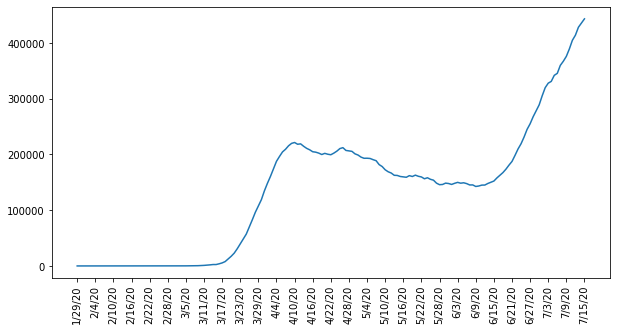

In [14]:
figure = plt.figure(figsize = (10,5))
plt.plot(increased_case)
plt.xticks(np.arange(0, len(increased_case.dropna()), 6)) 
plt.xticks(rotation=90)
plt.savefig("Infected Case.jpg",  bbox_inches='tight')

In [15]:
# covid_lib.plot_all( total_cases, increased_case, yhat , "US" )

---

### Full Model Building

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:993: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Test RMSE: 20.446


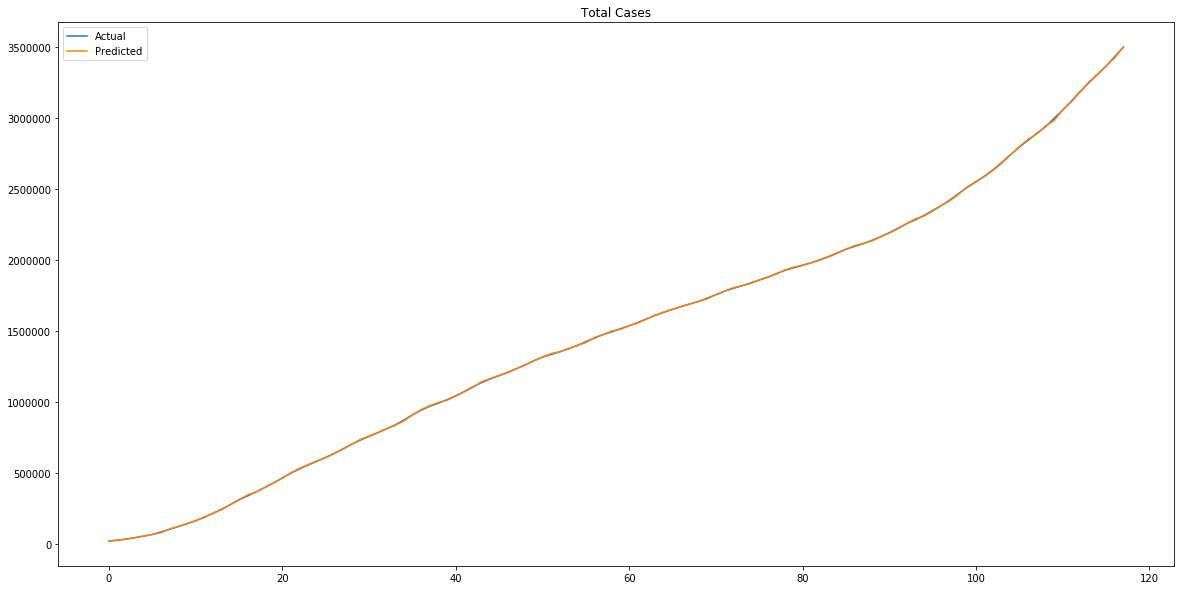

In [16]:
## This only predicts for one day
predictions_total, model_total = covid_lib.SARIMA_PREDICT(total_cases,"Total Cases", order_tuple = (0,1,0), fit_param = (True, True))

#### Predict future total Cases

In [17]:
# # today and tomorrow
# temp = model_total.forecast(14)
# plt.plot(temp)

---

#### Count Increase Model Building

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Test RMSE: 17.623


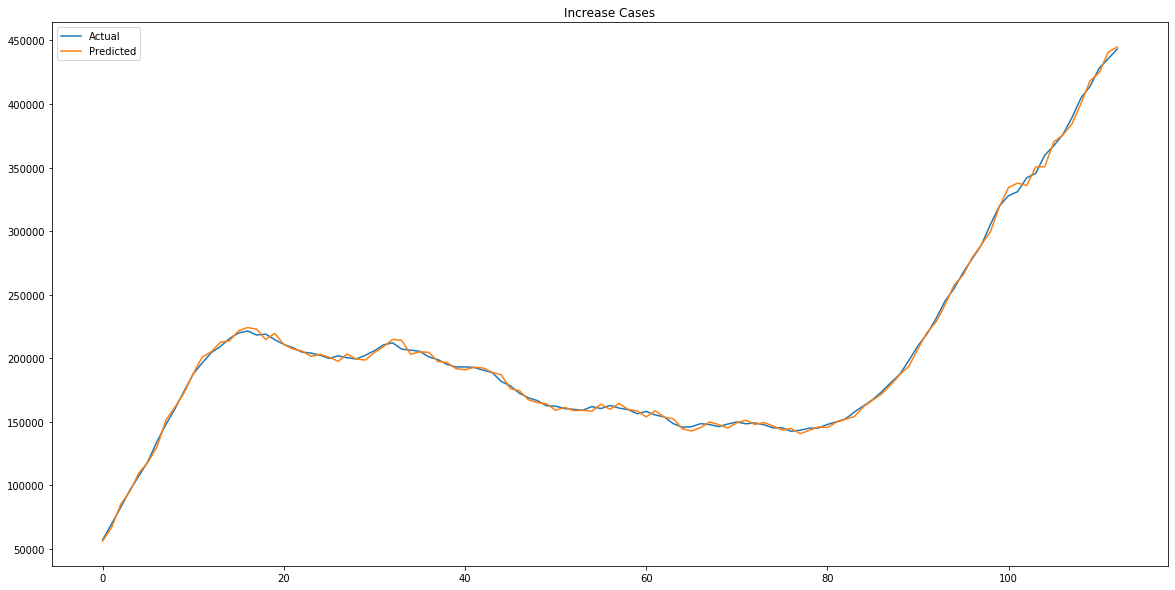

In [18]:
increase_temp = increased_case.values 
predictions_increase, model_increase = covid_lib.SARIMA_PREDICT(increase_temp, "Increase Cases",  is_increase_case = True, fit_param = (True,True) )

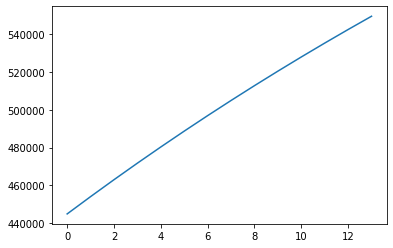

In [19]:
# today and tomorrow
temp = model_increase.forecast(14)
plt.plot(temp)

---

9203.272667129453

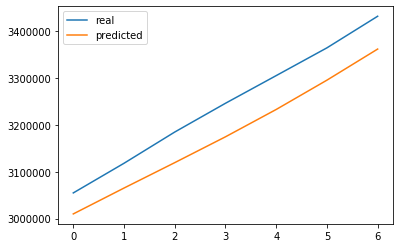

In [20]:
one_week_feature, one_week_target = covid_lib.split_sequence(total_cases.transpose()[0], 7)
two_week_feature, two_week_target = covid_lib.split_sequence(total_cases.transpose()[0], 14)

train_owf, train_owt, test_owf, test_owt = covid_lib.train_test_split_timeseries(one_week_feature, one_week_target)


covid_lib.LSTM_PREDICT(feature = train_owf,
     target = train_owt, 
     test_feature = test_owf,
     test_target = test_owt ,
     n_features = 1,
     n_steps = 7)

In [21]:
# np.save("./test files/in_seq1",in_seq1)
# np.save("./test files/in_seq2",in_seq2)
# np.save("./test files/out_seq",out_seq)
# np.save("./test files/test_input",test_input)

In [22]:
test_input =np.load("./test files/test_input.npy") 
in_seq1 = np.load("./test files/in_seq1.npy")
in_seq2 = np.load("./test files/in_seq2.npy")
out_seq = np.load("./test files/out_seq.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:


    
# define input sequence
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))

# choose a number of time steps
n_steps = 7

# convert into input/output
# print(dataset)
X, y = split_sequences(dataset, n_steps) 
n_features = X.shape[2]

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model 
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction 


lstm_predictions = []
for i in range(0 , len(testtt)-7):
    lstm_predictions.append(testtt[i][0])
    
for i in range(0 , len(test_input)-7):
    test_input_segment = array(test_input[i:i+7]) 
    x_input = test_input_segment.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0) 
    lstm_predictions.append(yhat[0][0])

NameError: name 'split_sequences' is not defined

In [ ]:
plt.plot(in_seq1_ar)
plt.plot(out_seq)
plt.plot(lstm_predictions)
plt.legend(["SARIMA Prediction" , "Real Value" , "Boosted LSTM"])
# plt.savefig("BoostedLSTMDay7.png")